<a href="https://colab.research.google.com/github/PiyumaliSandunika/e18-4yp-Multimodal-Emotion-Prediction-Using-Reinforcement-Learning/blob/main/Text_model/initial_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split


In [1]:
pip install accelerate

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/FYP_Text/tweet_emotions.csv")

In [4]:
df['sentiment'].value_counts()

sentiment
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64

In [5]:
df_org = df.sample(frac=1.0, random_state=42)
df_org = df_org.drop('tweet_id',axis =1 )
# rename 'hate'as 'anger' in sentiments
df_org['sentiment'] = df_org['sentiment'].replace('hate','anger')
# rename love,fun as joy
df_org['sentiment'] = df_org['sentiment'].replace(['love','fun'],'happiness')
# rename worry,boredom as sadness
df_org['sentiment'] = df_org['sentiment'].replace('worry','sadness')
df_org = df_org[df_org['sentiment'].apply(lambda x: x not in ['worry','love','fun','surprise','relief','hate','empty','enthusiasm','boredom'])]
print(df_org['sentiment'].value_counts())

sentiment
sadness      13624
happiness    10827
neutral       8638
anger         1433
Name: count, dtype: int64


In [6]:
min_count = df_org['sentiment'].value_counts().min()
df_org = df_org.groupby('sentiment').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
print(df_org['sentiment'].value_counts())


sentiment
anger        1433
happiness    1433
neutral      1433
sadness      1433
Name: count, dtype: int64


In [7]:
df = df_org

In [8]:
# Extract sentences and labels
texts = df["content"].tolist()
labels = df["sentiment"].tolist()

In [9]:
# Convert emotion labels to numerical values
label_map = {"happiness": 0, "sadness": 1, "anger": 2, "neutral": 3}
labels = [label_map[label] for label in labels]


In [10]:
from sklearn.model_selection import train_test_split
# Split data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2)
# split dataset into train validation and test



In [11]:
# Load pre-trained DistilBERT model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Tokenize data
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [13]:
# Create PyTorch datasets
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)



In [14]:
train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)


In [ ]:
# from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

# # Define hyperparameter search space
# param_grid = {
#     'learning_rate': [1e-5, 2e-5, 3e-5],
#     'batch_size': [16, 32, 64],
#     'num_train_epochs': [3, 4, 5],
#     'weight_decay': [0.01, 0.001, 0.0001],
#     'dropout_rate': [0.1, 0.2, 0.3]
# }

# # Define model and tokenizer
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')



In [15]:
# # Freeze all layers except for the classification head
# for param in model.parameters():
#     param.requires_grad = False
# for param in model.classifier.parameters():
#     param.requires_grad = True

In [15]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

In [16]:
from sklearn.metrics import accuracy_score

# Define a function to compute accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    return {"accuracy": accuracy}

In [17]:
# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

# # Define hyperparameter search space
# param_grid = {
#     'learning_rate': [1e-5, 2e-5, 3e-5],
#     'batch_size': [16, 32, 64],
#     'num_train_epochs': [3, 4, 5],
#     'weight_decay': [0.01, 0.001, 0.0001],
#     'dropout_rate': [0.1, 0.2, 0.3]
# }

# # Define model and tokenizer
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# # Define Trainer and TrainingArguments (not shown here)

# # Define RandomizedSearchCV
# random_search = RandomizedSearchCV(estimator=Trainer(model=model, args=training_args),
#                                    param_distributions=param_grid,
#                                    n_iter=10,
#                                    scoring='accuracy',
#                                    cv=3,
#                                    verbose=2,
#                                    random_state=42,
#                                    n_jobs=-1)

# # Perform random search
# random_search.fit(train_dataset)

# # Get best hyperparameters
# best_hyperparameters = random_search.best_params_

# print("Best Hyperparameters:", best_hyperparameters)


In [ ]:
# Train the model
trainer.train()

# Access training history



Step,Training Loss
500,1.109400
1000,0.680700
1500,0.299600
2000,0.146200
2500,0.077800
3000,0.043600
3500,0.049400
4000,0.039000
4500,0.047400
5000,0.045800


In [ ]:
train_history = trainer.state.log_history
print(train_history)

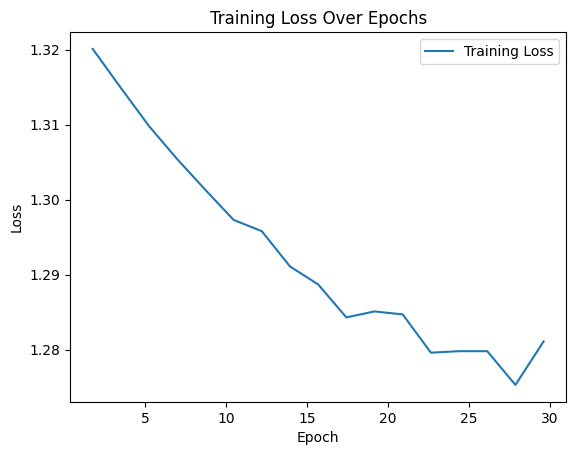

In [36]:
# Extract loss and epoch values from training history
loss_values = [entry.get('loss') for entry in train_history]
epochs = [entry.get('epoch') for entry in train_history]

# Plot training loss over epochs
plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [41]:
evaluation_results = trainer.evaluate()

# Print accuracy
print("Accuracy:", evaluation_results['eval_accuracy'])

Accuracy: 0.4952048823016565


In [40]:
# Save the trained model
trainer.save_model("/content/drive/MyDrive/FYP_Text/FYP_Text_30_epochs_frozen_layers/")

In [39]:
import pickle

# Save the trained model
model_path = "/content/drive/MyDrive/FYP_Text/FYP_Text_30_epochs_frozen_layers.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
